In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, r2_score, precision_score, classification_report)
from sklearn.preprocessing import StandardScaler

In [3]:
class DataLoader:
    """Handles data loading and preprocessing"""
    
    def __init__(self, start_date=None, end_date=None):
        self.start_date = start_date or (datetime.now() - timedelta(days=20*365))
        self.end_date = end_date or datetime.now()
        self.data = None
    def load_data(self, source='yahoo'):
        """Load data from specified source"""
        if source == 'synthetic':
            return self._create_synthetic_data()
        elif source == 'yahoo':
            print("Enter stock ticker symbol (e.g., AAPL, ^SPX):")
            stock_code = input().strip()
            return self._load_from_yahoo(stock_code)
        else:
            raise ValueError(f"Source '{source}' not supported")
    def _create_synthetic_data(self):
        """Generate synthetic market data"""
        np.random.seed(42)
        dates = pd.date_range(start=self.start_date, end=self.end_date, freq='B')
        prices = np.cumsum(np.random.normal(0, 10, len(dates))) + 3000
        volume = np.random.normal(1e6, 2e5, len(dates))
        
        self.data = pd.DataFrame({
            'Date': dates,
            'Close': prices,
            'Volume': volume,
            'Open': prices + np.random.normal(0, 5, len(dates)),
            'High': prices + np.random.normal(5, 2, len(dates)),
            'Low': prices - np.random.normal(5, 2, len(dates))
        })
        return self.data
    def _load_from_yahoo(self, stock_code):
        """Download historical market data"""
        try:
            self.data = yf.download(
                stock_code,
                start=self.start_date.strftime('%Y-%m-%d'),
                end=self.end_date.strftime('%Y-%m-%d')
            )
            self.data.reset_index(inplace=True)
            return self.data
        except Exception as e:
            print(f"Error downloading data: {e}")
            return None
    def preprocess_data(self, problem_type='regression'):
        """Prepare data for ML tasks with feature engineering"""
        if self.data is None:
            raise ValueError("Load data first")
            
        # Basic features
        self.data['SMA_20'] = self.data['Close'].rolling(20).mean()
        self.data['SMA_50'] = self.data['Close'].rolling(50).mean()
        self.data['Return'] = self.data['Close'].pct_change()
        
        # Target variables
        if problem_type == 'regression':
            self.data['Target'] = self.data['Close'].shift(-5)
        else:
            # Fixed alignment using vectorized operations
            self.data['Target'] = (self.data['Close'].shift(-1).values > 
                                  self.data['Close'].values).astype(int)
        
        # Advanced feature engineering
        horizons = [2, 5, 60, 250, 1000]
        for horizon in horizons:
            rolling_avg = self.data['Close'].rolling(horizon).mean()
            self.data[f'Close_Ratio_{horizon}'] = self.data['Close'] / rolling_avg
            if problem_type == 'classification':
                self.data[f'Trend_{horizon}'] = self.data['Target'].shift(1).rolling(horizon).sum()
        
        self.data.dropna(inplace=True)
        return self.data

In [4]:
class FeatureEngineer:
    """Handles feature selection and processing"""
    
    @staticmethod
    def get_features(problem_type='classification'):
        """Return appropriate feature set"""
        base_features = ['Close', 'Volume', 'Open', 'High', 'Low',
                        'SMA_20', 'SMA_50', 'Return']
        advanced_features = [f'Close_Ratio_{h}' for h in [2,5,60,250,1000]] + \
                          [f'Trend_{h}' for h in [2,5,60,250,1000]]
        
        return advanced_features if problem_type == 'classification' else base_features

In [5]:
class ModelBuilder:
    """Creates and manages ML models"""
    
    def __init__(self, problem_type='classification'):
        self.problem_type = problem_type
        self.model = self._create_model()
        
    def _create_model(self):
        """Instantiate appropriate model"""
        if self.problem_type == 'regression':
            return LinearRegression()
        return RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
    
    def train(self, X, y):
        """Train the model"""
        self.model.fit(X, y)
    
    def predict(self, X):
        """Generate predictions"""
        return self.model.predict(X)

In [6]:
class Backtester:
    """Handles backtesting functionality"""
    
    @staticmethod
    def backtest(data, model, features, problem_type='classification', start=2500, step=250):
        """Perform rolling window backtesting"""
        all_predictions = []
        for i in range(start, data.shape[0], step):
            train = data.iloc[0:i].copy()
            test = data.iloc[i:(i+step)].copy()
            predictions = Backtester._predict(train, test, features, model, problem_type)
            all_predictions.append(predictions)
        return pd.concat(all_predictions)
    
    @staticmethod
    def _predict(train, test, features, model, problem_type):
        """Make predictions for backtesting window"""
        model.fit(train[features], train['Target'])
        preds = model.predict(test[features])
        return pd.concat([
            test['Target'],
            pd.Series(preds, index=test.index, name='Predictions')
        ], axis=1)

In [7]:
class FinancialAnalyzer:
    """Main analysis pipeline controller"""
    
    def __init__(self, problem_type='classification'):
        self.problem_type = problem_type
        self.loader = DataLoader()
        self.features = FeatureEngineer.get_features(problem_type)
        self.model = ModelBuilder(problem_type)
        self.results = None
    def run_full_analysis(self):
        """Execute complete analysis workflow"""
        # Load and prepare data
        self.loader.load_data('yahoo')
        self.loader.preprocess_data(self.problem_type)
        data = self.loader.data
        
        # Initial train-test split
        train = data.iloc[:-100]
        test = data.iloc[-100:]
        
        # Train primary model
        self.model.train(train[self.features], train['Target'])
        
        # Initial predictions
        test_preds = self.model.predict(test[self.features])
        
        # Backtesting (problem-specific)
        backtest_preds = Backtester.backtest(data, self.model.model, self.features, self.problem_type)
        
        # Evaluate results
        self._evaluate_results(test['Target'], test_preds, backtest_preds)
        self._plot_results(test['Target'], test_preds)
        
        return self.results
    def _evaluate_results(self, y_test, test_preds, backtest_preds):
        """Calculate and store performance metrics"""
        self.results = {
            'test_metrics': self._get_metrics(y_test, test_preds),
            'backtest_metrics': self._get_metrics(backtest_preds['Target'], backtest_preds['Predictions']),
            'feature_importances': self._get_feature_importances()
        }
    def _get_metrics(self, y_true, y_pred):
        """Return appropriate metrics based on problem type"""
        if self.problem_type == 'regression':
            return {
                'mse': mean_squared_error(y_true, y_pred),
                'r2': r2_score(y_true, y_pred)
            }
        return {
            'precision': precision_score(y_true, y_pred)
        }
    def _get_feature_importances(self):
        """Return feature importance/coefficients"""
        if self.problem_type == 'regression':
            return dict(zip(self.features, self.model.model.coef_))
        return dict(zip(self.features, self.model.model.feature_importances_))
    def _plot_results(self, y_true, y_pred):
        """Generate result visualizations"""
        plt.figure(figsize=(12, 6))
        if self.problem_type == 'regression':
            plt.scatter(y_true, y_pred, alpha=0.5)
            plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
            plt.title("Actual vs Predicted Prices")
            plt.xlabel("Actual Prices")
            plt.ylabel("Predicted Prices")
        else:
            combined = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
            combined.plot(title='Actual vs Predicted Market Movements')
        plt.show()

Main execution flow

*** STOCK PRICE ANALYSIS SYSTEM ***

Running Regression Analysis...
Enter stock ticker symbol (e.g., AAPL, ^SPX):
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


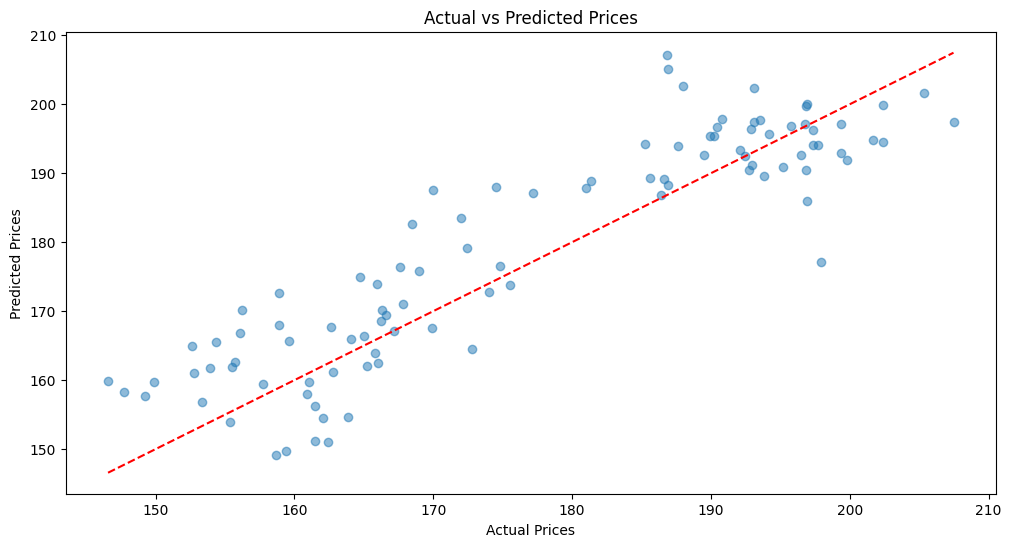


=== Regression Results ===
Test RÂ² Score: 0.78
Backtest MSE: 24.54

Top Feature Coefficients:
Close: 0.8515
Return: 0.6320
Low: -0.1976
High: 0.1449
Open: 0.1359

Running Classification Analysis...
Enter stock ticker symbol (e.g., AAPL, ^SPX):


[*********************100%***********************]  1 of 1 completed


<Figure size 1200x600 with 0 Axes>

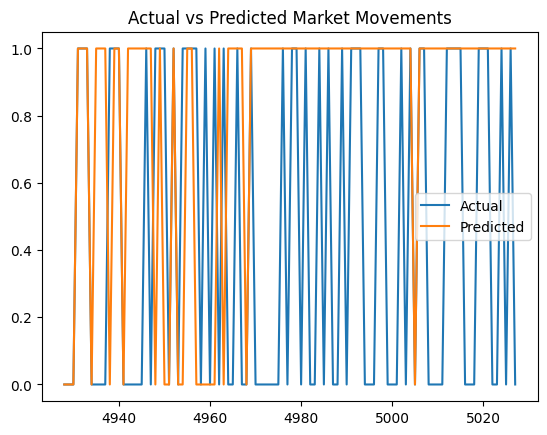


=== Classification Results ===
Test Precision: 0.46
Backtest Precision: 0.55

Top Feature Importances:
Close_Ratio_5: 0.1575
Close_Ratio_2: 0.1511
Close_Ratio_60: 0.1482
Close_Ratio_1000: 0.1424
Close_Ratio_250: 0.1360


In [8]:
if __name__ == "__main__":
    print("*** STOCK PRICE ANALYSIS SYSTEM ***")
    
    # Run regression analysis
    print("\nRunning Regression Analysis...")
    regressor = FinancialAnalyzer(problem_type='regression')
    reg_results = regressor.run_full_analysis()
    
    print("\n=== Regression Results ===")
    print(f"Test RÂ² Score: {reg_results['test_metrics']['r2']:.2f}")
    print(f"Backtest MSE: {reg_results['backtest_metrics']['mse']:.2f}")
    
    print("\nTop Feature Coefficients:")
    for feat, coef in sorted(reg_results['feature_importances'].items(), 
                           key=lambda x: abs(x[1]), reverse=True)[:5]:
        print(f"{feat}: {coef:.4f}")
    
    # Run classification analysis
    print("\nRunning Classification Analysis...")
    classifier = FinancialAnalyzer(problem_type='classification')
    cls_results = classifier.run_full_analysis()
    
    print("\n=== Classification Results ===")
    print(f"Test Precision: {cls_results['test_metrics']['precision']:.2f}")
    print(f"Backtest Precision: {cls_results['backtest_metrics']['precision']:.2f}")
    
    print("\nTop Feature Importances:")
    for feat, imp in sorted(cls_results['feature_importances'].items(), 
                          key=lambda x: x[1], reverse=True)[:5]:
        print(f"{feat}: {imp:.4f}")

In [ ]:
import joblib
joblib.dump(modelL, 'models/my_model.pkl')

NameError: name 'FINAL' is not defined